## CIFAR 10

classification (10 classes) 

CIFAR 10 consists of: 60,000 tiny 32 x 32 color RGB images

labeled with integer 1 to 10 classes 

airplane (0), car (1), etc. 


In [5]:

import torch
import numpy as np
## import imageio
import os

import torch.optim as optim
import torch.nn as nn

from torchvision import datasets
from torchvision import transforms

import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, accuracy_score, f1_score




In [6]:
data_path = 'data/cifar10data/'

cifar10 = datasets.CIFAR10(data_path, train=True, download=True)

Files already downloaded and verified


In [7]:
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified


In [8]:
cifar10 = datasets.CIFAR10(data_path, train=True, download=False)

In [9]:
print(cifar10)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/cifar10data/
    Split: Train


In [10]:
img, label = cifar10[79]

In [11]:
label

1

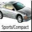

In [12]:
img

In [13]:
print(   dir(transforms)   )

['AugMix', 'AutoAugment', 'AutoAugmentPolicy', 'CenterCrop', 'ColorJitter', 'Compose', 'ConvertImageDtype', 'FiveCrop', 'GaussianBlur', 'Grayscale', 'InterpolationMode', 'Lambda', 'LinearTransformation', 'Normalize', 'PILToTensor', 'Pad', 'RandAugment', 'RandomAdjustSharpness', 'RandomAffine', 'RandomApply', 'RandomAutocontrast', 'RandomChoice', 'RandomCrop', 'RandomEqualize', 'RandomErasing', 'RandomGrayscale', 'RandomHorizontalFlip', 'RandomInvert', 'RandomOrder', 'RandomPerspective', 'RandomPosterize', 'RandomResizedCrop', 'RandomRotation', 'RandomSolarize', 'RandomVerticalFlip', 'Resize', 'TenCrop', 'ToPILImage', 'ToTensor', 'TrivialAugmentWide', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_pil_constants', '_presets', 'autoaugment', 'functional', 'functional_pil', 'functional_tensor', 'transforms']


In [14]:
print(img)


<PIL.Image.Image image mode=RGB size=32x32 at 0x1F7764A63D0>


In [15]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)

print(img_t.shape)

torch.Size([3, 32, 32])


The transforms can be passed directly to tnhe entire dataset

In [16]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())

In [17]:
img_t , _ = tensor_cifar10[99]

In [18]:
print(img_t)

tensor([[[0.2431, 0.1961, 0.1804,  ..., 0.6549, 0.7176, 0.5373],
         [0.2471, 0.2157, 0.2039,  ..., 0.6392, 0.6706, 0.5686],
         [0.2275, 0.2510, 0.2196,  ..., 0.6000, 0.5882, 0.4824],
         ...,
         [0.6745, 0.5608, 0.5098,  ..., 0.3686, 0.5529, 0.5451],
         [0.7176, 0.5882, 0.3137,  ..., 0.3176, 0.5294, 0.5608],
         [0.8196, 0.7137, 0.5451,  ..., 0.2314, 0.5098, 0.6627]],

        [[0.2510, 0.1961, 0.1725,  ..., 0.6745, 0.7216, 0.5333],
         [0.2549, 0.2078, 0.1961,  ..., 0.6627, 0.6824, 0.5725],
         [0.2431, 0.2588, 0.2353,  ..., 0.6078, 0.6039, 0.5020],
         ...,
         [0.5294, 0.4314, 0.2196,  ..., 0.2941, 0.4235, 0.4118],
         [0.5725, 0.4627, 0.2510,  ..., 0.2824, 0.4627, 0.4902],
         [0.6824, 0.5922, 0.4275,  ..., 0.2118, 0.4667, 0.6118]],

        [[0.1725, 0.1020, 0.0745,  ..., 0.2706, 0.2980, 0.2824],
         [0.1451, 0.1020, 0.1059,  ..., 0.2392, 0.2941, 0.3020],
         [0.1412, 0.1451, 0.1451,  ..., 0.2431, 0.2510, 0.

## Normalize



In [19]:

imgs_list = [ img_t  for img_t, _ in tensor_cifar10 ]

imgs = torch.stack( imgs_list, dim=3 )



In [20]:
print(   imgs.shape   )

torch.Size([3, 32, 32, 50000])


In [21]:
view1 = imgs.view(3, -1)
print(view1.shape)


torch.Size([3, 51200000])


In [22]:
view1 = view1.mean(dim=1)
print(view1)

tensor([0.4914, 0.4822, 0.4465])


In [23]:
view2 = imgs.view(3, -1).std(dim=1)
print(view2)

tensor([0.2470, 0.2435, 0.2616])


In [24]:


transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download= False,
                                      transform = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize(view1, view2)
                                      ]))


transformed_cifar10_val = datasets.CIFAR10(data_path, train=False, download= False,
                                      transform = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize(view1, view2)
                                      ]))



## Build dataset

In [25]:
label_map = {0:0, 2:1}

In [26]:
class_names = ['airplane', 'bird']

In [27]:
cifar2 = [  (img, label_map[label])  for img, label in transformed_cifar10 if label in [0, 2]    ]

In [28]:
cifar2_val = [  (img, label_map[label])  for img, label in transformed_cifar10_val if label in [0, 2]    ]

## Softmax

In [29]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [30]:
x = torch.tensor(   [1.0, 2.0, 3.0 ]   )

In [31]:
print(   softmax(x).sum()   )

tensor(1.)



## Architectures


In [32]:

n_out = 2 

model_mlp = nn.Sequential(
          nn.Linear(3072, 512),
          nn.Tanh(),
          nn.Linear(512, n_out),
          nn.Softmax(dim=1)
)



In [33]:

model_2DL = nn.Sequential(
     nn.Linear(3072, 1024),
     nn.ReLU(),                  ## nn.GeLU()
     nn.Linear(1024, 512),
     nn.ReLU(),
     nn.Linear(512, 128),
     nn.ReLU(),
     nn.Linear(128, 2),
     nn.LogSoftmax(dim=1)
)


In [49]:

## negative log likelihood

## loss_fn = nn.NLLLoss()

loss_fn = nn.CrossEntropyLoss()



## DataLoader


In [50]:

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)


In [51]:

## model_fn = model_mlp
model_fn = model_2DL


## Training process

In [52]:

learning_rate = 0.001  ## 1e-2    ## 0.001

n_epochs = 100

## optimizer = optim.SGD(  model_fn.parameters(), lr=learning_rate )
optimizer = optim.Adam(  model_fn.parameters(), lr=learning_rate )



In [53]:

for epoch in range(n_epochs):
    for imgs, labels in train_loader:       ## imgs [64x3x32x32]
        ## print(imgs.shape)
        ## resize for network
        batch_size = imgs.shape[0]
        imgs_resized = imgs.view(batch_size, -1)    ## imgs_resized [64, 3072]
        ## print(imgs_resized.shape)
        outputs = model_fn(imgs_resized)
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(loss)


tensor(0.3791, grad_fn=<NllLossBackward0>)
tensor(0.3750, grad_fn=<NllLossBackward0>)
tensor(0.5521, grad_fn=<NllLossBackward0>)
tensor(0.3310, grad_fn=<NllLossBackward0>)
tensor(0.1398, grad_fn=<NllLossBackward0>)
tensor(0.8638, grad_fn=<NllLossBackward0>)
tensor(0.2040, grad_fn=<NllLossBackward0>)
tensor(0.3896, grad_fn=<NllLossBackward0>)
tensor(0.4379, grad_fn=<NllLossBackward0>)
tensor(0.1516, grad_fn=<NllLossBackward0>)
tensor(0.1693, grad_fn=<NllLossBackward0>)
tensor(0.0872, grad_fn=<NllLossBackward0>)
tensor(0.0264, grad_fn=<NllLossBackward0>)
tensor(0.0921, grad_fn=<NllLossBackward0>)
tensor(0.1013, grad_fn=<NllLossBackward0>)
tensor(0.0620, grad_fn=<NllLossBackward0>)
tensor(0.0816, grad_fn=<NllLossBackward0>)
tensor(0.0024, grad_fn=<NllLossBackward0>)
tensor(0.1911, grad_fn=<NllLossBackward0>)
tensor(0.2181, grad_fn=<NllLossBackward0>)
tensor(0.1774, grad_fn=<NllLossBackward0>)
tensor(0.0684, grad_fn=<NllLossBackward0>)
tensor(0.1925, grad_fn=<NllLossBackward0>)
tensor(0.32

## After training, now testing

In [54]:

val_loader = torch.utils.data.DataLoader(   cifar2_val, batch_size=2000, shuffle=False  )


In [43]:

temp_metric = 0
total   = 0


In [45]:

with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs    = model_fn(    imgs.view(batch_size, -1)     )
        _, pred = torch.max(  outputs, dim=1  )
        
        temp_metric =  temp_metric +  int( (pred == labels).sum()  )
        total       = total + batch_size

print(   temp_metric/total    )
        


0.857


## All performance metrics

In [55]:

print(len(cifar2_val))


2000


In [56]:

val_loader = torch.utils.data.DataLoader(   cifar2_val, batch_size=2000, shuffle=False  )


In [57]:

def print_stats_percentage_train_test(algorithm_name, y_test, y_pred):    
     print("------------------------------------------------------")
     print("------------------------------------------------------")
    
     print("algorithm is: ", algorithm_name)
        
     print('Accuracy: %.2f' % accuracy_score(y_test,   y_pred) )
     
     confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
     print("confusion matrix")
     print(confmat)
     print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
     print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
     print('F1-measure: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average='weighted'))
   


In [58]:

with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs    = model_fn(    imgs.view(batch_size, -1)     )
        _, preds = torch.max(  outputs, dim=1  )
        print_stats_percentage_train_test("2DL", labels, preds)
        




------------------------------------------------------
------------------------------------------------------
algorithm is:  2DL
Accuracy: 0.84
confusion matrix
[[879 121]
 [190 810]]
Precision: 0.846
Recall: 0.845
F1-measure: 0.844
